## Analyzing Infrastructure Quality (download/upload speed and latency) by Country (Thailand, Mexico, South Africa)

1. Data Acquisition

    Accessed Ookla Open Data for Q1 2025 fixed broadband performance.

    Downloaded the relevant .parquet file and inspected its structure.

    Reconstructed geospatial tile geometry from quadkey values using the mercantile library.

2. Geometry Construction

    Converted quadkeys into bounding boxes (shapely.box) using mercantile.bounds.

    Built a GeoDataFrame (gdf) with performance metrics and geometry in WGS84 (EPSG:4326).

3. Country Filtering

    Downloaded and loaded country boundaries from Natural Earth (ne_110m_admin_0_countries.shp).

    Selected target countries: Thailand, Mexico, and South Africa.

    Ensured coordinate reference systems matched before spatial join.

4. Spatial Join

    Used geopandas.sjoin() to select only tiles intersecting the target countries.

    Resulted in a clean performance dataset specific to each country.

5. Metric Aggregation

    Calculated average download speed, average upload speed, and average latency per country.

    Created a summary table and confirmed Thailand’s dominant performance.

6. Visualization

    Built horizontal bar charts for all three KPIs (download, upload, latency), sorted by performance.

    Used invert_yaxis() in plots to place top performers at the top for intuitive reading.


https://ookla-open-data.s3.amazonaws.com/

https://www.speedtest.net/global-index/thailand

https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/

In [ ]:
%matplotlib inline

import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd
from shapely.geometry import box

In [50]:
import requests

# url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/parquet/performance/type%3Dfixed/year%3D2025/quarter%3D1/2025-01-01_performance_fixed_tiles.parquet"

url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/parquet/performance/type%3Dmobile/year%3D2025/quarter%3D1/2025-01-01_performance_mobile_tiles.parquet"

local_filename = "data/2025_Q1_mobile_tiles.parquet"

with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print("Download complete!")

Download complete!


In [51]:
# Load the parquet file as a regular DataFrame
df = pd.read_parquet("data/2025_Q1_mobile_tiles.parquet")

In [52]:
print(df.columns.tolist())

['quadkey', 'tile', 'tile_x', 'tile_y', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms', 'avg_lat_up_ms', 'tests', 'devices']


In [21]:
import mercantile

In [22]:
# Convert quadkeys to tile bounds and create geometries
def quadkey_to_geom(qk):
    tile = mercantile.quadkey_to_tile(qk)
    bounds = mercantile.bounds(tile)
    return box(bounds.west, bounds.south, bounds.east, bounds.north)

df["geometry"] = df["quadkey"].apply(quadkey_to_geom)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")  # WGS84

print("Tiles with geometry loaded!")

Tiles with geometry loaded!


In [25]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6364159 entries, 0 to 6364158
Data columns (total 12 columns):
 #   Column           Dtype   
---  ------           -----   
 0   quadkey          object  
 1   tile             object  
 2   tile_x           float64 
 3   tile_y           float64 
 4   avg_d_kbps       int64   
 5   avg_u_kbps       int64   
 6   avg_lat_ms       int64   
 7   avg_lat_down_ms  float64 
 8   avg_lat_up_ms    float64 
 9   tests            int64   
 10  devices          int64   
 11  geometry         geometry
dtypes: float64(4), geometry(1), int64(5), object(2)
memory usage: 582.7+ MB


In [53]:
def quadkey_to_geom(qk):
    tile = mercantile.quadkey_to_tile(qk)
    bounds = mercantile.bounds(tile)
    return box(bounds.west, bounds.south, bounds.east, bounds.north)

df["geometry"] = df["quadkey"].apply(quadkey_to_geom)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
print("Mobile tiles with geometry loaded!")

Mobile tiles with geometry loaded!


In [54]:
world = gpd.read_file("C:/Users/deyna/Desktop/telecom-market/data/ne_110m_admin_0_countries.shp")

targets = world[world["NAME"].isin(["Thailand", "Mexico", "South Africa"])]

In [55]:
# Align coordinate systems just in case
targets = targets.to_crs(gdf.crs)

# Perform spatial join
filtered_tiles = gpd.sjoin(gdf, targets, how="inner", predicate="intersects")

In [57]:
filtered_tiles = gpd.sjoin(gdf, targets, how="inner", predicate="intersects")

summary = (
    filtered_tiles.groupby("NAME")[["avg_d_kbps", "avg_u_kbps", "avg_lat_ms"]]
    .mean()
    .round(2)
    .rename(columns={
        "avg_d_kbps": "Avg Download (Kbps)",
        "avg_u_kbps": "Avg Upload (Kbps)",
        "avg_lat_ms": "Avg Latency (ms)"
    })
)

print("Mobile Network Performance Summary:\n")
print(summary)

Mobile Network Performance Summary:

              Avg Download (Kbps)  Avg Upload (Kbps)  Avg Latency (ms)
NAME                                                                  
Mexico                   52590.06           16196.01             60.58
South Africa             74446.27           14360.73             33.81
Thailand                 71482.37           17079.49             31.05


Note: higher speeds and lower latency are better for eSIM quality.

Highlights:

  - Thailand

      - Strongest all-around performance

      - Second-fastest download speed (~71.5 Mbps)

      - Highest upload speed

      - Lowest latency at just 31 ms—ideal for eSIM usage like VoIP, streaming, and real-time apps

  - South Africa

      - Fastest download speed (~74.4 Mbps), a pleasant surprise

      - Upload speed trails slightly

      - Moderate latency (34 ms), making it quite competitive

  - Mexico

      - Lowest download speed (~52.6 Mbps) and highest latency (~60.6 ms)

      - Solid upload speed, but overall least favorable performance among the three



  Thailand still shines as the most balanced and reliable market across all key KPIs. South Africa's download speed gives it an edge, but slightly weaker latency and uploads may impact consistency. Mexico lags behind in responsiveness, which could affect user satisfaction with eSIM-enabled services.

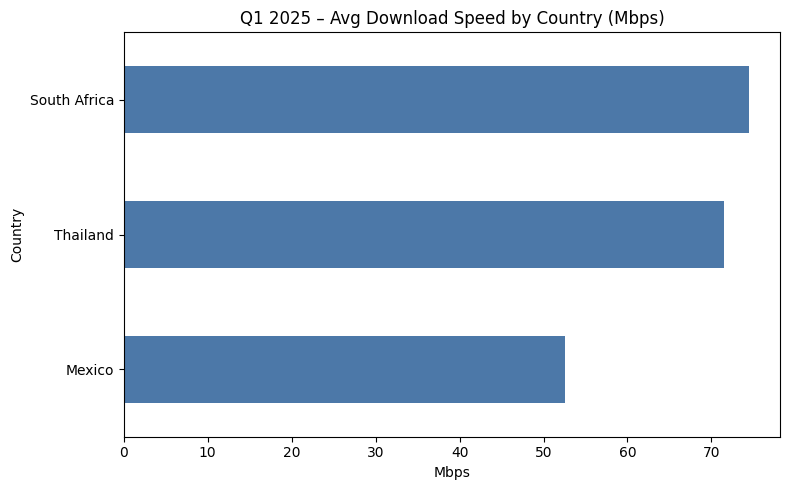

In [58]:
summary_sorted = summary.sort_values("Avg Download (Kbps)", ascending=False)
summary_sorted["Avg Download (Mbps)"] = summary_sorted["Avg Download (Kbps)"] / 1000

summary_sorted["Avg Download (Mbps)"].plot(
    kind="barh",
    color="#4c78a8",
    figsize=(8, 5),
    title="Q1 2025 – Avg Download Speed by Country (Mbps)"
)

plt.xlabel("Mbps")
plt.ylabel("Country")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


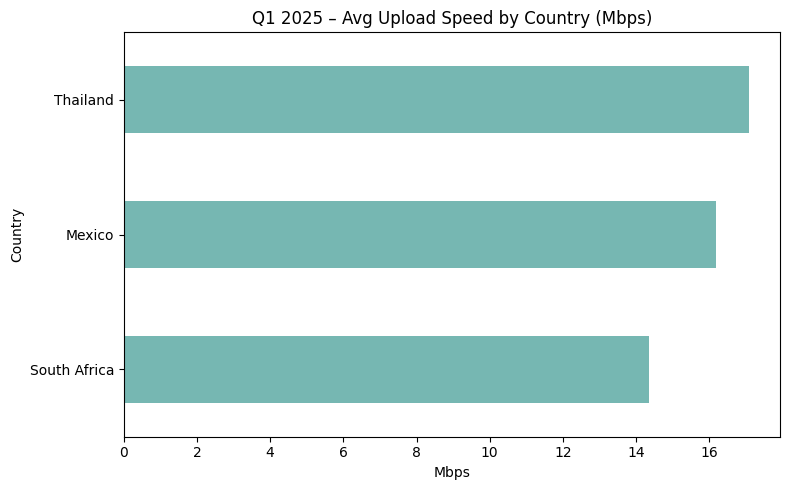

In [59]:
summary_sorted = summary.sort_values("Avg Upload (Kbps)", ascending=False)
summary_sorted["Avg Upload (Mbps)"] = summary_sorted["Avg Upload (Kbps)"] / 1000

summary_sorted["Avg Upload (Mbps)"].plot(
    kind="barh",
    color="#76b7b2",
    figsize=(8, 5),
    title="Q1 2025 – Avg Upload Speed by Country (Mbps)"
)

plt.xlabel("Mbps")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

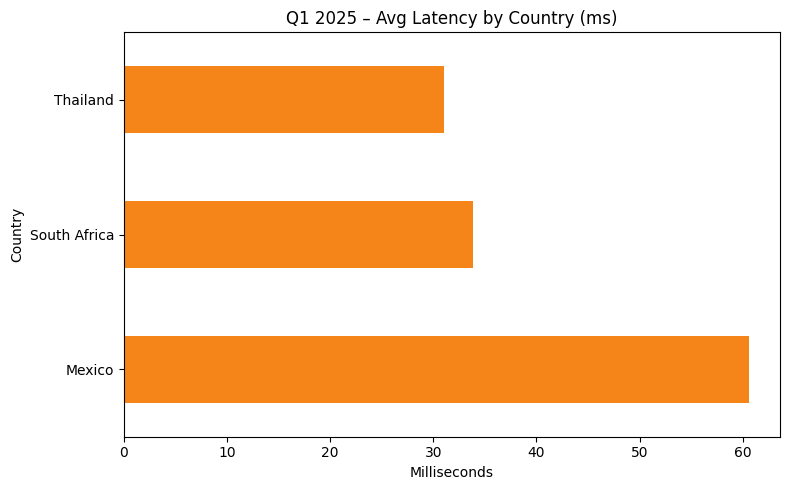

In [60]:
summary_sorted = summary.sort_values("Avg Latency (ms)", ascending=True)

summary_sorted["Avg Latency (ms)"].plot(
    kind="barh",
    color="#f58518",
    figsize=(8, 5),
    title="Q1 2025 – Avg Latency by Country (ms)"
)

plt.xlabel("Milliseconds")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()